# 12 terminals systems

We primarily use this model to calcualate the difference between the top and bottom surfaces`s σ. 


In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import tinyarray

sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

I_4= tinyarray.array(np.kron(sigma_0, sigma_0))
gamma_1 = tinyarray.array(np.kron(sigma_0, sigma_z))
gamma_2 = tinyarray.array(np.kron(sigma_z, sigma_z))
gamma_3 = tinyarray.array(np.kron(sigma_0, sigma_y))
gamma_4 = tinyarray.array(np.kron(sigma_0, sigma_x))

B=-300
g=300
D=-25 
las=1

structure=kwant.lattice.square(las, norbs=4)
model_sym= kwant.TranslationalSymmetry(structure.vec((-1,0)),structure.vec((0,-1)))

def onsite(site,m):
    return m/2*gamma_1 - (4*B)/las**2 * gamma_2 + D * gamma_2

hopping_x = B/(las**2)*gamma_2 + 1j*g/(2*las)*gamma_3
hopping_y = B/(las**2)*gamma_2 - 1j*g/(2*las)*gamma_4

def model_MTI():
    model_1= kwant.Builder(model_sym)

    model_1[structure(0, 0)] = onsite
    model_1[kwant.builder.HoppingKind((1,0), structure)]  = hopping_x
    model_1[kwant.builder.HoppingKind((0,1), structure)]  = hopping_y

    return model_1

def model_EG():

    onsite_leads= 150 *I_4
    hopping_leads= -150 *I_4

    model_2= kwant.Builder(model_sym)
    model_2[structure(0, 0)] = onsite_leads
    model_2[structure.neighbors()]  = hopping_leads

    return model_2

def make_syst(width=50,length=220,leads_model=model_EG()):
    
    ########### create the scattering center

    def shape_center(site):
        x, y = site.pos
        return 0 < x <= length and 0 < y <= width

    syst= kwant.Builder()
    syst.fill(model_MTI(), shape_center,(1,1))

    ########### create the leads

    width_lead = length//11

    lead0= kwant.Builder(kwant.TranslationalSymmetry((-1,0)))
    lead1= kwant.Builder(kwant.TranslationalSymmetry((0,1)))
    lead2= kwant.Builder(kwant.TranslationalSymmetry((0,1)))
    lead3= kwant.Builder(kwant.TranslationalSymmetry((0,1)))
    lead4= kwant.Builder(kwant.TranslationalSymmetry((0,1)))
    lead5= kwant.Builder(kwant.TranslationalSymmetry((0,1)))
    
    def shape_lead0(site):
        x, y = site.pos
        return 0 < y <= width

    def shape_lead1(site):
        x, y = site.pos
        return width_lead < x <= 2*width_lead

    def shape_lead2(site):
        x, y = site.pos
        return 3*width_lead < x <= 4*width_lead
    
    def shape_lead3(site):
        x, y = site.pos
        return 5*width_lead < x <= 6*width_lead
    
    def shape_lead4(site):
        x, y = site.pos
        return 7*width_lead < x <= 8*width_lead
    
    def shape_lead5(site):
        x, y = site.pos
        return 9*width_lead < x <= 10*width_lead

    lead0.fill(leads_model, shape_lead0, (0, 1))
    lead1.fill(leads_model, shape_lead1, (width_lead+1, 0))
    lead2.fill(leads_model, shape_lead2, (3*width_lead+1, 0))
    lead3.fill(leads_model, shape_lead3, (5*width_lead+1, 0))
    lead4.fill(leads_model, shape_lead4, (7*width_lead+1, 0))
    lead5.fill(leads_model, shape_lead5, (9*width_lead+1, 0))

    ########### create the six-terminal device
    for lead in [lead0,lead1,lead2,lead3,lead4,lead5, lead0.reversed(),lead5.reversed(),lead4.reversed(),lead3.reversed(),lead2.reversed(),lead1.reversed()]:
        syst.attach_lead(lead)

    return syst.finalized()




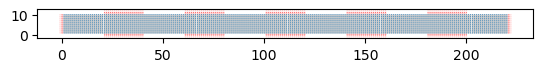

In [2]:
syst_1=make_syst(width=10,leads_model=model_MTI())
kwant.plot(syst_1) ;

## Band structure

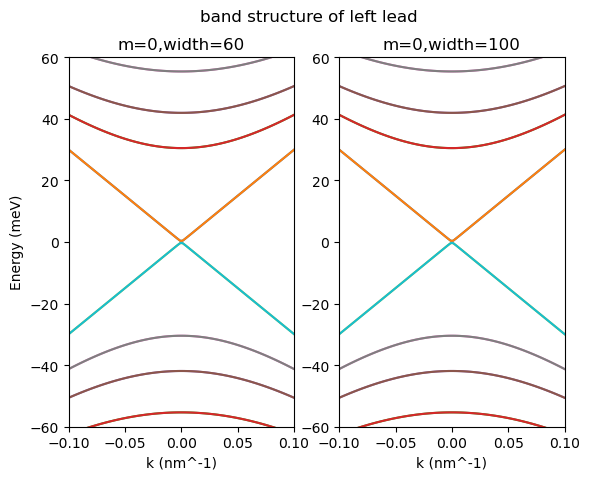

In [3]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('band structure of left lead')

x_lim=0.1
y_lim=60
ax1.set_ylabel('Energy (meV)')
ax1.set_title('m=0,width=60')
ax2.set_title('m=0,width=100')
for ax in (ax1,ax2):
    ax.set_xlabel('k (nm^-1)')
    ax.set_ylim(-y_lim,y_lim)
    ax.set_xlim(-x_lim,x_lim)

syst1=make_syst(width=60, length=330, leads_model=model_MTI()).leads[0]
syst2=make_syst(width=60,length=330, leads_model=model_MTI()).leads[0]

kwant.plotter.bands(syst1,momenta=np.linspace(-x_lim, x_lim, 100), ax=ax1, params=dict(m=0));
kwant.plotter.bands(syst2,momenta=np.linspace(-x_lim, x_lim, 100), ax=ax2, params=dict(m=0));

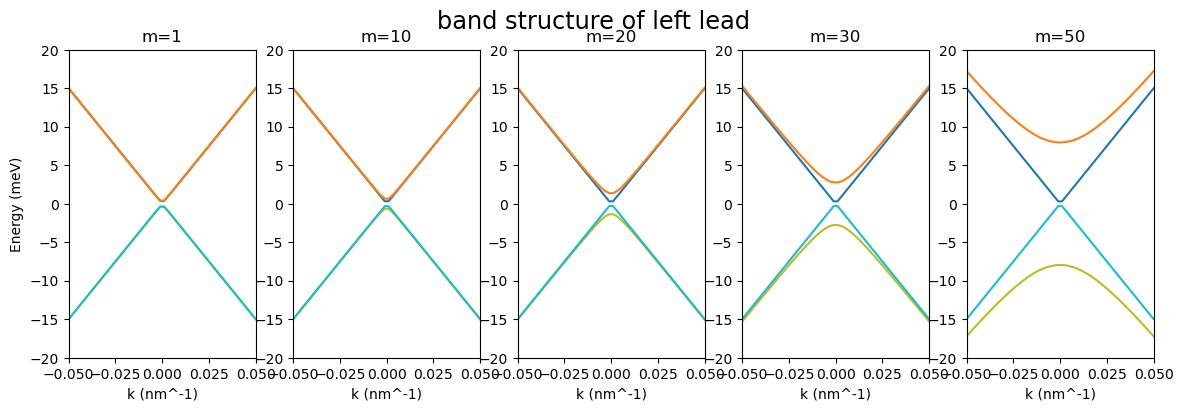

In [4]:
syst1=make_syst(width=60,length=330,leads_model=model_MTI()).leads[0]

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize=(14, 4))
fig.suptitle('band structure of left lead', size='xx-large')
y_limit = 20
x_limit = 0.05
ax1.set_ylabel('Energy (meV)')
for ax in zip((ax1,ax2,ax3,ax4,ax5),(1,10,20,30,50)):
    ax[0].set_xlabel('k (nm^-1)')
    ax[0].set_ylim(-y_limit,y_limit)
    ax[0].set_xlim(-x_limit,x_limit)
    ax[0].set_title(f'm={ax[1]}')
    kwant.plotter.bands(syst1,momenta=np.linspace(-x_limit,x_limit , 50), ax=ax[0], params=dict(m=ax[1]));


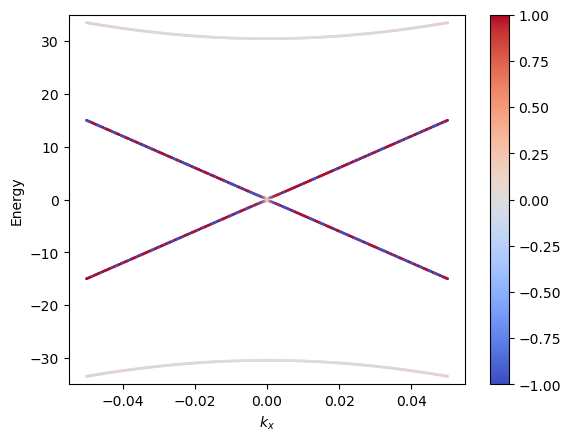

In [5]:
syst1=make_syst(width=60,length=330,leads_model=model_MTI()).leads[0]

bands = kwant.physics.Bands(syst1, params=dict(m=0))
momenta=np.linspace(-0.05, 0.05, 200)

es=[]
evs=[]
for k in momenta:
    tem_a,tem_b= bands(k=k,return_eigenvectors = True) 
    es.append(tem_a)
    evs.append(tem_b)

zcolors=[]
for k in range(len(momenta)):
    tem_1=[]
    for i in range(np.array(es).shape[1]):
            swf=np.reshape(np.abs(evs[k][:,i])**2,(-1,2)).sum(1)
            tem_c=swf.reshape(2,-1).sum(1)
            tem_1.append(tem_c[0]-tem_c[1])
    zcolors.append(tem_1)    

for i in range(np.array(es).shape[1]):
    plt.scatter(momenta,np.array(es)[:,i],s=1,c=np.array(zcolors)[:,i],cmap="coolwarm",vmin=-1.,vmax=1.)
plt.ylim(-35,35)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.colorbar();

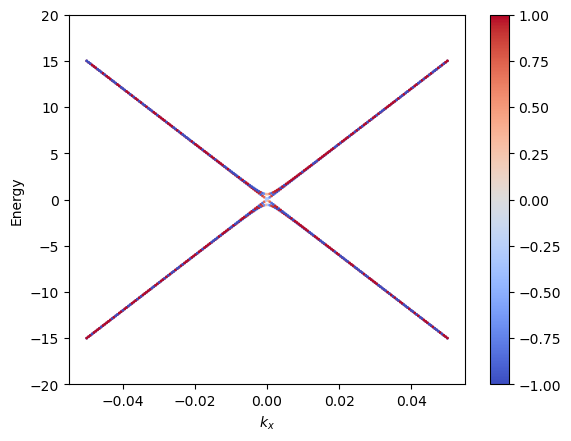

In [6]:
syst=make_syst(width=60,length=330,leads_model=model_MTI()).leads[0]

bands = kwant.physics.Bands(syst, params=dict(m=10))
momenta=np.linspace(-0.05, 0.05, 200)

es=[]
evs=[]
for k in momenta:
    tem_a,tem_b= bands(k=k,return_eigenvectors = True) 
    es.append(tem_a)
    evs.append(tem_b)

for i in range(np.array(es).shape[1]):
    plt.scatter(momenta,np.array(es)[:,i],s=1,c=np.array(zcolors)[:,i],cmap="coolwarm",vmin=-1.,vmax=1.)
plt.ylim(-20,20)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.colorbar();

## Density of current

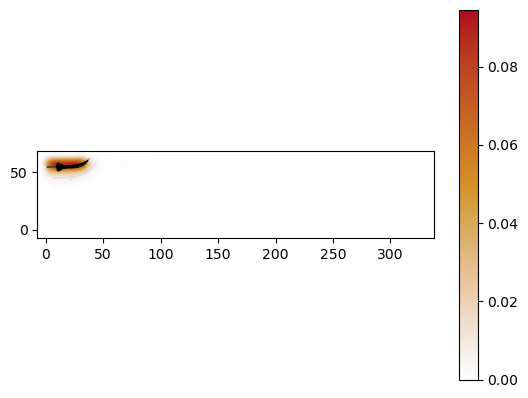

In [7]:
fsyst = make_syst(width=60,length=330,leads_model=model_MTI())

J=kwant.operator.Current(fsyst)            #这个对象是一个电流算符，可以用来计算系统 fsyst 中任意两个相邻格点（跳跃，hopping）之间的局部电流密度。wf[0][0] 通常表示从第一个引线注入的波函数在第一个自旋/轨道通道中的分量（具体取决于模型的自由度）。
wf=kwant.wave_function(fsyst, energy=8,params=dict(m=20))  #它是一个包含了已计算好的散射波函数集合的对象。
psi=wf(0)[0]                               #为什么只有一个一个轨道模型
current = J(psi)
kwant.plotter.current(fsyst, current, colorbar=True, show=True)

## Distribution of wavefuncion

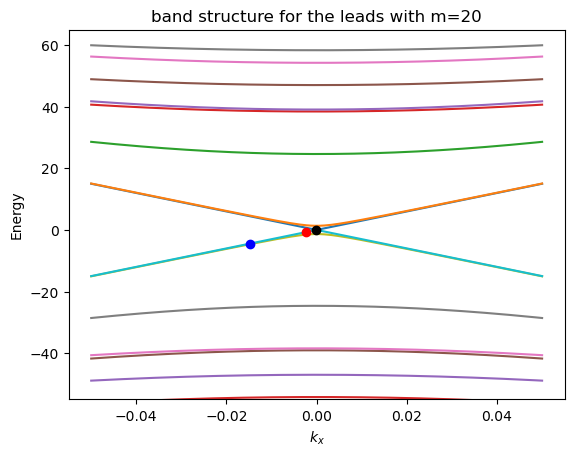

In [8]:
syst1=make_syst(width=60,length=330,leads_model=model_MTI()).leads[0]

bands = kwant.physics.Bands(syst1, params=dict(m=20))
momenta=np.linspace(-0.05, 0.05, 200)

es=[]
evs=[]
for k in momenta:
    tem_a,tem_b= bands(k=k,return_eigenvectors = True) 
    es.append(tem_a)
    evs.append(tem_b)

# the 100th, 96th and 70th states (k values) are chosen, the 120th energy level (band) is chosen
plt.plot(momenta,es);
plt.plot(momenta[99], es[99][119], 'ko')
plt.plot(momenta[95], es[95][119], 'ro')
plt.plot(momenta[70], es[70][119], 'bo')
plt.ylim(-55,65)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.title('band structure for the leads with m=20');

Text(0, 0.5, 'possibility of the wavefunction')

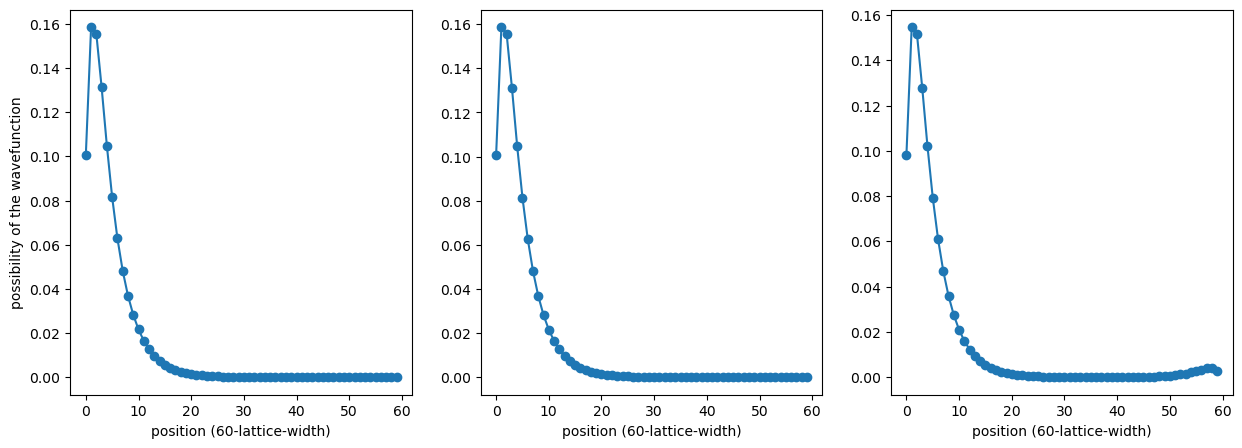

In [9]:
swf1=np.abs(evs[70][:,119])**2
swf2=np.abs(evs[95][:,119])**2
swf3=np.abs(evs[99][:,119])**2
fig,(ax1,ax2,ax3)=plt.subplots(1,3, figsize=(15,5))
ax1.plot(range(60),swf1.reshape((-1,4)).sum(1),'-o')
ax2.plot(range(60),swf2.reshape((-1,4)).sum(1),'-o')
ax3.plot(range(60),swf3.reshape((-1,4)).sum(1),'-o')

for ax in (ax1,ax2,ax3):
    ax.set_xlabel('position (60-lattice-width)')
ax1.set_ylabel('possibility of the wavefunction')

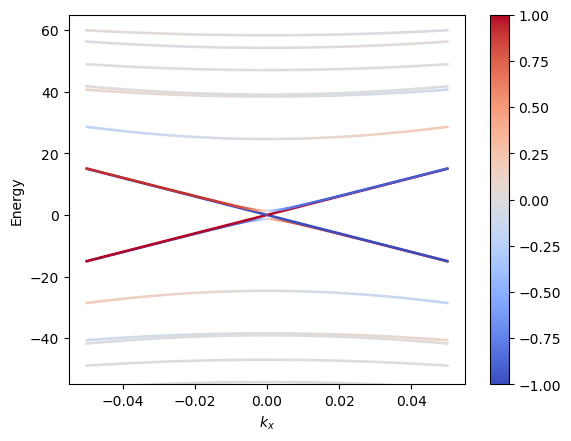

In [10]:
zcolors=[]
for k in range(len(momenta)):
    tem_1=[]
    for i in range(np.array(es).shape[1]):
            swf=np.reshape(np.abs(evs[k][:,i])**2,(-1,2)).sum(1)
            tem_c=swf.reshape(2,-1).sum(1)
            tem_1.append(tem_c[0]-tem_c[1])
    zcolors.append(tem_1)

    
#1
for i in range(np.array(es).shape[1]):
    plt.scatter(momenta,np.array(es)[:,i],s=1,c=np.array(zcolors)[:,i],cmap="coolwarm",vmin=-1.,vmax=1.)
plt.ylim(-55,65)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.colorbar();

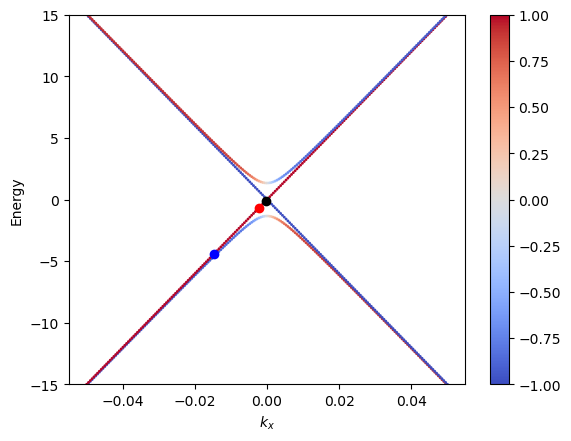

In [11]:
#1.1
for i in range(np.array(es).shape[1]):
    plt.scatter(momenta,np.array(es)[:,i],s=1,c=np.array(zcolors)[:,i],cmap="coolwarm",vmin=-1.,vmax=1.)
plt.plot(momenta[70], es[70][119], 'bo')
plt.plot(momenta[95], es[95][119], 'ro')
plt.plot(momenta[99], es[99][119], 'ko')
plt.ylim(-15,15)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.colorbar();

## R vs E

In [12]:
def find_voltages(tmatrix,current):
    try:
        voltage = np.linalg.solve(tmatrix[1:, 1:], current[1:])
    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            print("Hi there, singular matrix here")
            voltage = [0,0,0,0,0,0,0,0,0,0,0]
        else:
            raise
    return [0, *voltage]

def resistance_xx(tmatrix):
    current = [1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0]
    voltage = find_voltages(tmatrix,current)
    
    def resistance(lead1, lead2):
        return voltage[lead1-1]-voltage[lead2-1]

    return resistance(2, 6)

def resistance_xy(tmatrix):
    current = [1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0]
    voltage = find_voltages(tmatrix,current)
    
    def resistance(lead1, lead2):
        return voltage[lead1-1]-voltage[lead2-1]

    return resistance(2, 12)

def rMplot(m_list, data, ptitle='resistance vs m'):
    rxx=[]
    rxy=[]
    for i in range(data.shape[0]):
        rxx.append(resistance_xx(data[i]))
        rxy.append(resistance_xy(data[i]))

    plt.plot(m_list,rxx,'-o', label='$R_{xx}$')
    plt.plot(m_list,rxy,'-o', label='$R_{xy}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('m')
    plt.ylabel('Resistance')
    plt.legend()


# define a function to plot the resistance vs energy
# here, "data" is a "np.array", a list (different energy) of 6*6 transimission matrices=[]
def rEplot(energies, data, ptitle='resistance vs energy'):
    rxx=[]
    rxy=[]
    for i in range(data.shape[0]):
        rxx.append(resistance_xx(data[i]))
        rxy.append(resistance_xy(data[i]))

    plt.plot(energies,rxx,'-o', label='$R_{xx}$')
    plt.plot(energies,rxy,'-o', label='$R_{xy}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('Energy')
    plt.ylabel('Resistance')
    plt.legend()

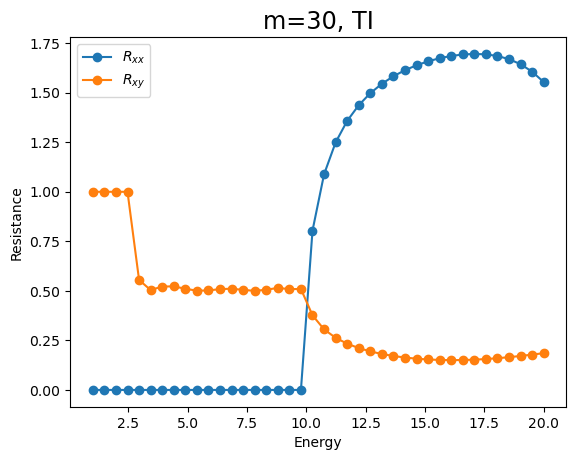

In [13]:
syst0=make_syst(width=60,length=330,leads_model=model_MTI())

data0=[]
e_range=np.linspace(1,20,num=40)
for energy in e_range:
    tmatrix = kwant.smatrix(syst0, energy,params=dict(m=30))
    data0.append(tmatrix.conductance_matrix())

rEplot(e_range,np.array(data0),"m=30, TI")    

Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here


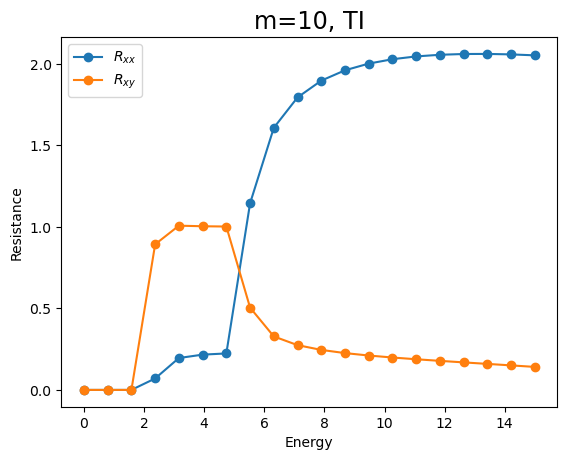

In [14]:
syst_A=make_syst(width=30,length=330,leads_model=model_MTI())

data=[]
e_range=np.linspace(0,15,num=20)
for energy in e_range:
    tmatrix = kwant.smatrix(syst_A, energy,params=dict(m=10))
    data.append(tmatrix.conductance_matrix())

rEplot(e_range,np.array(data),"m=10, TI")

Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here


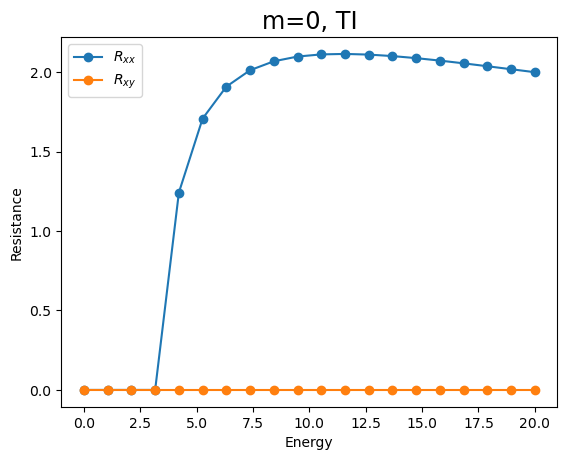

In [15]:
data=[]
e_range=np.linspace(0,20,num=20)
for energy in e_range:
    tmatrix = kwant.smatrix(syst_A, energy,params=dict(m=0))
    data.append(tmatrix.conductance_matrix())

rEplot(e_range,np.array(data),"m=0, TI")    

## R vs m

In [16]:
systm=make_syst(width=60,length=330,leads_model=model_MTI())

datae=[]
m_range=np.linspace(-60,60,num=31)
for m_value in m_range:
    tmatrix = kwant.smatrix(systm, 10.0,params=dict(m=m_value))
    datae.append(tmatrix.conductance_matrix())

# around 2 minutes    

In [17]:
np.round(datae[1],2)

array([[ 1., -1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0.,  1., -1., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0.,  1., -1., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0.,  1., -1., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0.,  1., -1., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0.,  1., -1., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0.,  1., -1., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0.,  1., -1., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0.,  1., -1., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0.,  1., -1., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,  1., -1.],
       [-1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,  1.]])

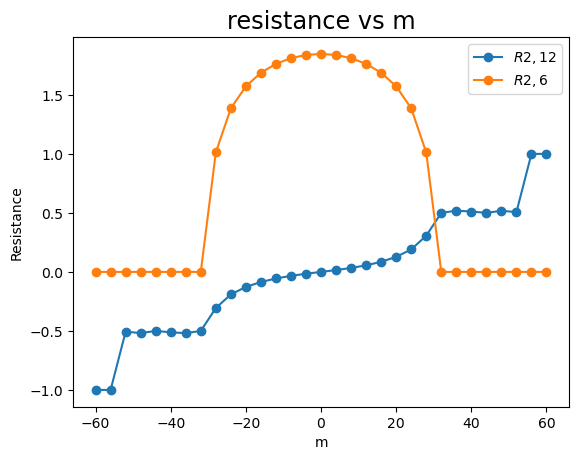

In [18]:
#任意端口
def rMplot_m(m_list, datae, lead1=2,lead2=5, ptitle='resistance vs m'):
    current = [1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0]
    rx=[]
    for i in range(datae.shape[0]):
        voltage = find_voltages(datae[i],current)
        rx.append(voltage[lead1-1]-voltage[lead2-1])

    plt.plot(m_list,rx,'-o', label=f'$R {lead1},{lead2}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('m')
    plt.ylabel('Resistance')
    plt.legend()

rMplot_m(m_range,np.array(datae),2,12)
rMplot_m(m_range,np.array(datae),2,6)



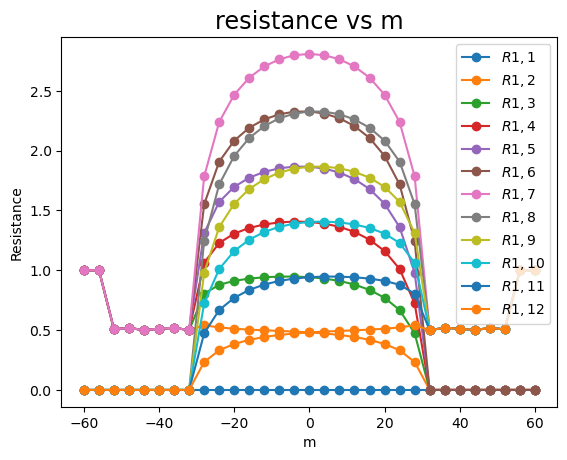

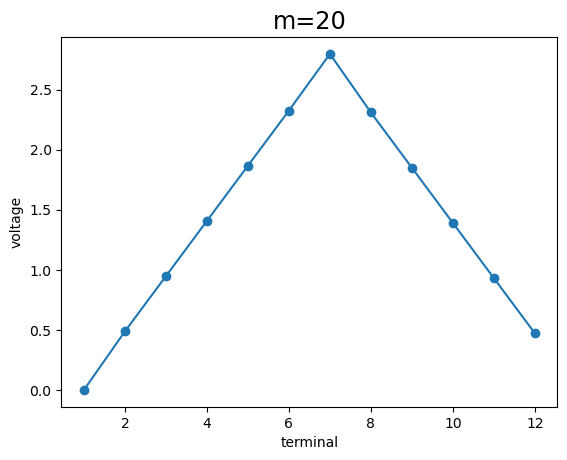

In [22]:
# One m, one resistance
r=[]
def rMplot_m(m_list, datae, lead1=2,lead2=5, ptitle='resistance vs m'):
    current = [1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0]
    rx=[]
    for i in range(datae.shape[0]):
        voltage = find_voltages(datae[i],current)
        rx.append(voltage[lead1-1]-voltage[lead2-1])
    r.append(rx[14])
    plt.plot(m_list,rx,'-o', label=f'$R {lead1},{lead2}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('m')
    plt.ylabel('Resistance')
    plt.legend()
# double 3

rMplot_m(m_range,np.array(datae),1,1)
rMplot_m(m_range,np.array(datae),1,2)
rMplot_m(m_range,np.array(datae),1,3)
rMplot_m(m_range,np.array(datae),1,4)
rMplot_m(m_range,np.array(datae),1,5)
rMplot_m(m_range,np.array(datae),1,6)
rMplot_m(m_range,np.array(datae),1,7)
rMplot_m(m_range,np.array(datae),1,8)
rMplot_m(m_range,np.array(datae),1,9)
rMplot_m(m_range,np.array(datae),1,10)
rMplot_m(m_range,np.array(datae),1,11)
rMplot_m(m_range,np.array(datae),1,12)
plt.show()

#voltage vs n
np.round(r,2)

plt.plot(range(1,13),r,'-o', label='R')
plt.title("m=20", size='xx-large')
plt.xlabel('terminal')
plt.ylabel('voltage')
plt.show()
